In [1]:
import pytesseract
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [137]:
img = cv2.imread('../images/agua/flat/IMG_20210322_101043130.jpg', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../images/agua/flat/IMG_20210322_100849338.jpg', cv2.IMREAD_GRAYSCALE)

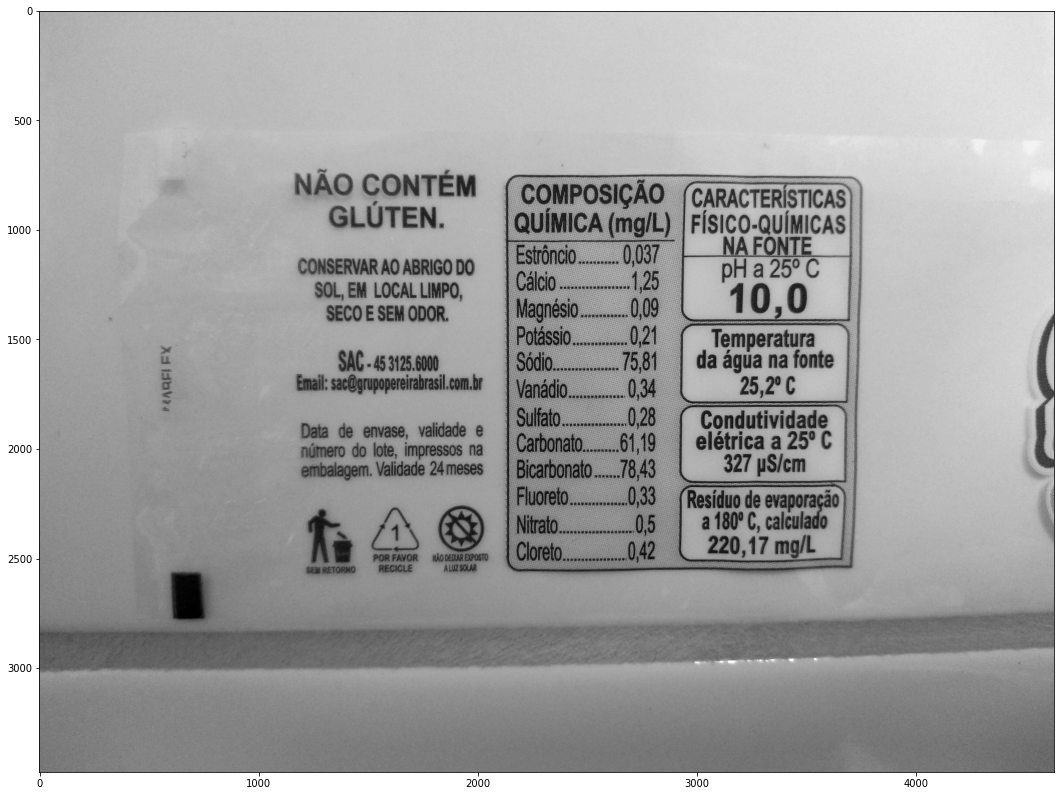

In [138]:
plt.figure(figsize=(220,14))
plt.imshow(img, cmap='gray')

In [124]:
mser = cv2.MSER_create()
regions, bounding_boxes = mser.detectRegions(img)

In [125]:
def calculate_rectangle_coordinates(bounding_box):
    x, y, w, h = bounding_box
    xmax = x + w
    ymax = y + h
    xmin = x
    ymin = y
    return ((xmax, ymax), (xmin, ymin))
    

In [126]:
def calculate_iou(bb_1, bb_2):
    (xmax_1, ymax_1), (xmin_1, ymin_1) = calculate_rectangle_coordinates(bb_1)
    (xmax_2, ymax_2), (xmin_2, ymin_2) = calculate_rectangle_coordinates(bb_2)
    
    x_left = max(xmin_1, xmin_2)
    y_top = max(ymin_1, ymin_2)
    x_right = min(xmax_1, xmax_2)
    y_bottom = min(ymax_1, ymax_2)

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    if x_right < x_left or y_bottom < y_top:
        return 0
    
    bb1_area = (xmax_1 - xmin_1) * (ymax_1 - ymin_1)
    bb2_area = (xmax_2 - xmin_2) * (ymax_2 - ymin_2)

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou

In [127]:
def filter_bounding_boxes(bounding_boxes, threshold=0.9):
    filtered_bb = [bounding_boxes[0]]
    for bb in bounding_boxes[1:]:
        iou = calculate_iou(filtered_bb[-1], bb)
        if iou >= threshold:
            filtered_bb.pop()
        
        filtered_bb.append(bb)

    return filtered_bb

In [128]:
def draw_bounding_boxes(image, bounding_boxes):
    vis = image.copy()
    for bb in bounding_boxes:
        (xmax, ymax), (xmin, ymin) = calculate_rectangle_coordinates(bb)
        cv2.rectangle(vis, (int(xmin), int(ymax)), (int(xmax), int(ymin)), (0, 0, 0), 1)
    return vis

In [129]:
def resize_bouding_boxes(bounding_boxes, amount):
    resized = []
    for bb in bounding_boxes:
        (xmax, ymax), (xmin, ymin) = calculate_rectangle_coordinates(bb)
        xmin = int((1 - amount) * xmin)
#         ymin = int((1 - amount) * ymin)
        xmax = int((1 + amount) * xmax)
#         ymax = int((1 + amount) * ymax)
        resized.append([xmin, ymin, xmax - xmin, ymax - ymin])
    return resized


In [130]:
def merge_boxes(bounding_boxes, threshold=10, amount=0.2, pixels_to_add=30):
    result = []
    idx_list = []

    for idx_current, bb_current in enumerate(bounding_boxes):
        
        if idx_current not in idx_list:
            (xmax_1, ymax_1), (xmin_1, ymin_1) = calculate_rectangle_coordinates(bb_current)
            idx_list.append(idx_current)
            width = xmax_1 - xmin_1
            xmax_1 += min(width * amount, pixels_to_add)
#             print(f"CURRENT=max({(xmax_1, ymax_1)}), min({(xmin_1, ymin_1)})")
            for idx_candidate, bb_candidate in enumerate(bounding_boxes[idx_current + 1:]):
                (xmax_2, ymax_2), (xmin_2, ymin_2) = calculate_rectangle_coordinates(bb_candidate)

                width = xmax_2 - xmin_2
                xmin_2 -= min(width * amount, pixels_to_add)
                xmax_2 += min(width * amount, pixels_to_add)
                
                
                x_left = max(xmin_1, xmin_2)
                y_top = max(ymin_1, ymin_2)
                x_right = min(xmax_1, xmax_2)
                y_bottom = min(ymax_1, ymax_2)
                
                
                intersection_area = (x_right - x_left) * (y_bottom - y_top)
                if x_right < x_left or y_bottom < y_top:
                    intersection_area = 0
                
#                 print(f"CANDIDATE=max({(xmax_2, ymax_2)}), min({(xmin_2, ymin_2)})")
                if intersection_area > threshold:
                    xmax_1 = max(xmax_1, xmax_2)
                    xmin_1 = min(xmin_1, xmin_2)
                    ymin_1 = min(ymin_1, ymin_2)
                    ymax_1 = max(ymax_1, ymax_2)
                    idx_list.append(idx_current + 1 + idx_candidate)
#                     print(f"UPDATED=max({(xmax_1, ymax_1)}), min({(xmin_1, ymin_1)}), AREA={intersection_area}")
                else:
                    break

            
            result.append([xmin_1, ymin_1, xmax_1 - xmin_1, ymax_1 - ymin_1])
#             print(f"LEN={len(result)}, NEW=max({(xmax_1, ymax_1)}), min({(xmin_1, ymin_1)}), w={xmax_1 - xmin_1}, h={ymax_1 - ymin_1}")
#             print("-----------------------------")

    return result
        

In [131]:
filtered = filter_bounding_boxes(bounding_boxes, threshold=0.7)
print(f"BEFORE={len(bounding_boxes)}, AFTER={len(filtered)}")

BEFORE=5799, AFTER=1050


In [134]:
merged = merge_boxes(filtered, threshold=0, pixels_to_add=100)
len(merged)
# merged_filter = filter_bounding_boxes(merged, threshold=0.7)

505

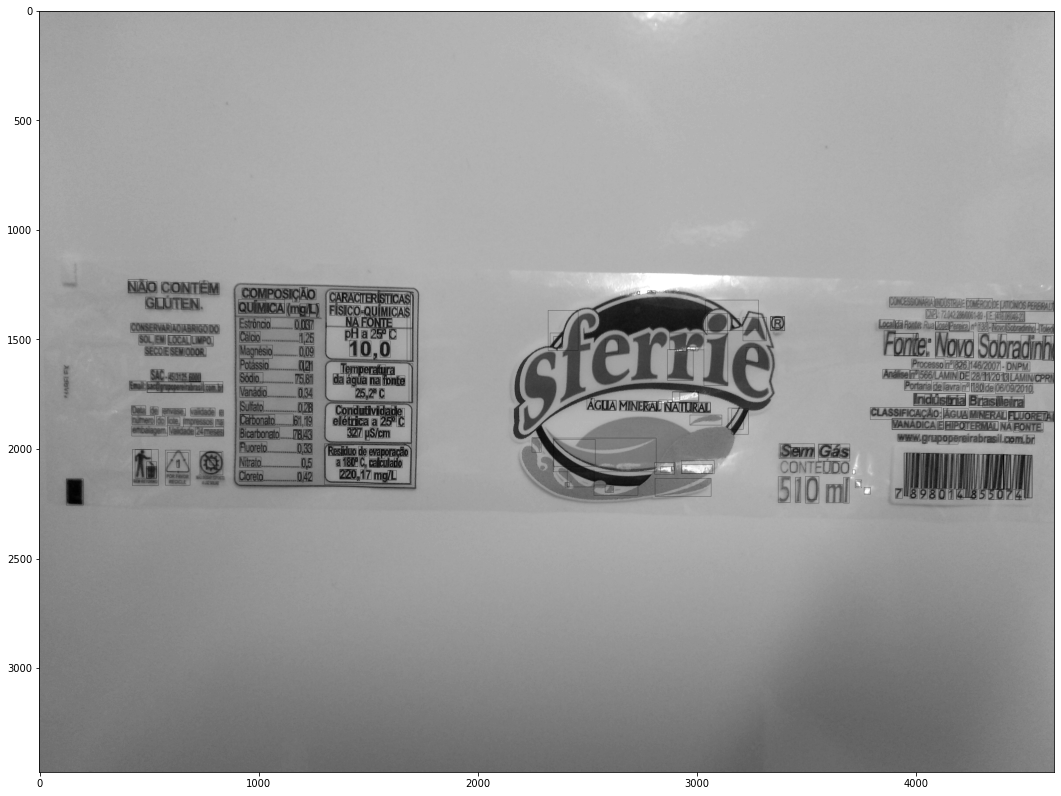

In [135]:
vis = draw_bounding_boxes(img, filtered)
plt.figure(figsize=(220,14))
plt.imshow(vis, cmap='gray')

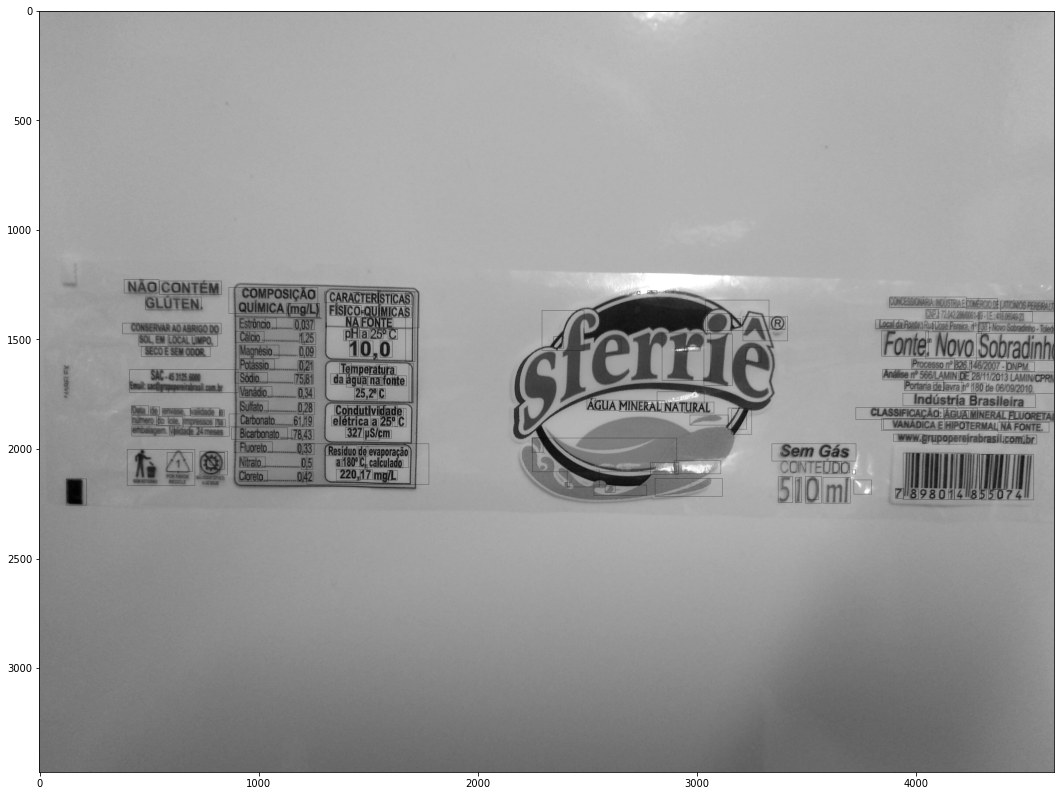

In [136]:
vis = draw_bounding_boxes(img, merged)
plt.figure(figsize=(220,14))
plt.imshow(vis, cmap='gray')